<img src="https://github.com/pastas/pastas/blob/dev/doc/_static/logo_graz.png?raw=true" align="right" width=250>

# Diagnostic checking of Pastas Models
*R.A. Collenteur, University of Graz, March 2020*

### Introduction

In this notebook it is shown how to perform diagnostic checking of a Pastas model. Diagnostic checking is a common step in time series modelling proces, subjecting a calibrated model to various statistical tests, to ensure that the model adequately describes the time series (Hipel & McLeod, 2005). Diagnostics checks are performed on the residual or noise series of a model, depending on whether or not a noisemodel was applied in the modelling process. We will refer to the series that was minimized during parameter estimation as the "residuals". In practice in Pastas models, these can come from `ml.noise()` or `ml.residuals()`.

### Why perform diagnostics checks?

Before we start the discussion of what to check, let's discuss the reasons why one might want to perform a diagnostic checking of the model results.

### What should be checked?

Regardless of this, the residuals series always have to comply with the same assumptions. After model calibration, it is tested if the residuals or noise series are: independent, homoscedastic (i.e. have a constant variance), and come from a Normal distribution. Of these three assumptions, the first is the most important, having the largest impact on the standard errors of the estimated parameters (Hipel & McLeod, 2005). Additionally to the above three assumptions, the model residuals should be uncorrelated with any of the input time series.

### On the interpretation of statistical tests
To perform diagnostic checks on the residual series different statistical tests are available in Pastas, Scipy and Statsmodels. These tests typically test a hypothesis with a version of the following general form of the Null hypothesis ($H_0$) and the Alternative hypothesis ($H_A$):

- $H_0$: The time series are [test] independent, homoscedastic, normally distributed
- $H_A$: The time series are not independent, homoscedastic, normally distributed

In pastas, all test results may be interpreted as follows: If a test returns `h=False`, the test fails to reject the Null hypothesis. This means that according to that specific test the data is in agreement with one of the assumptions outlined above. All of the tests compute a certain test statistic (e.g., $Z$), which is compared to a theoretical value according to a certain distribution (e.g., $\chi^2$) that depends on the level of significance (e.g., $\alpha=0.05$) and (often) the number of parameters to determine the degrees of freedom $h$.

### Content of this Notebook:

- [Checking for autocorrelation](#1.-Checking-for-autocorrelation)
- [Checking for Homoscedasticity](#2.-Checking-for-homoscedasticity)
- [Checking for Normality](#3.-Checking-for-Normal-distribution)
- [Diagnostic Checking in Pastas in Practice](#4.-Diagnostics-checking-in-practice)
- [Further Reading](#Further-Reading)

In [1]:
# Import necessary packages
import pandas as pd
import pastas as ps

import scipy.stats as stats
import matplotlib.pyplot as plt

ps.set_log_level("ERROR")

## 0. Create and calibrate a Pastas model 

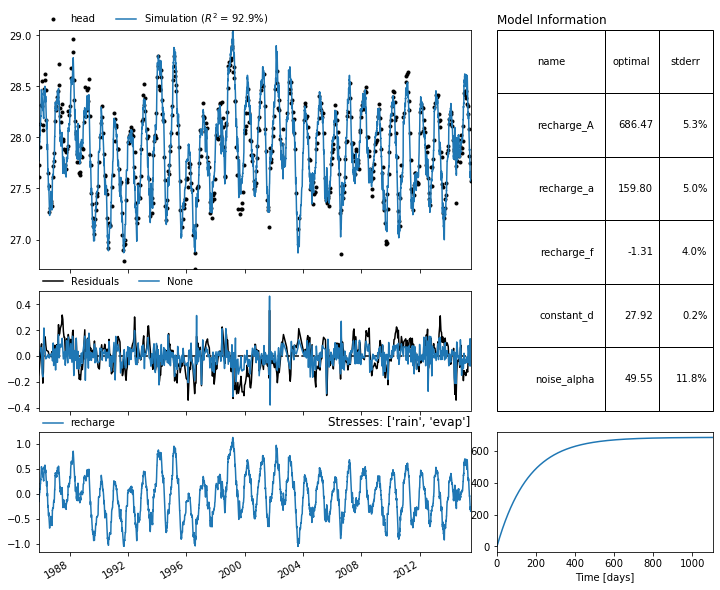

In [2]:
ml = ps.io.load("model.pas")
res = ml.noise()
ml.plots.results();

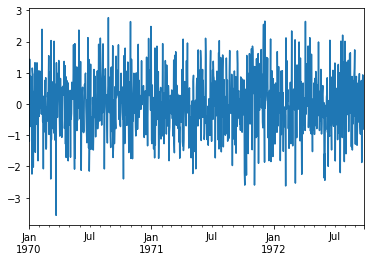

In [3]:
import numpy as np
random_seed = np.random.RandomState(1234)
index = pd.to_datetime(np.arange(1000), unit="D")
noise = pd.Series(random_seed.normal(0,1,1000), index=index)
noise.plot()

alpha = 0.05

## 1. Checking for autocorrelation
First we check if the model residuals are independent of each other and are thus not correlated. Since we are dealing with model residuals in time, we can refer to this correlation as autocorrelation. Whereas many time series models have equidistant time steps, the resisuals of Pastas models can have non-equidistant time steps. To deal with this property, functions have been implemented in Pastas that can deal with non-equidistant time steps. We therefore recommend to use the statistical methods supplied in Pastas, unless the modeller is sure he/she is dealing with equidistant time steps. See the additional Notebook on the autocorrelation function for more details and a proof of concept.

The following tests for autocorrelation are available:

- Autocorrelation (`ps.stats.acf`): Method to estimate the autocorrelation of a time series that also works for non-equidistant timesteps  
- Plot ACF (`ps.stats.plot_acf`): Visualisation of the autocorrelation and its confidence intervals.
- Ljung-Box test (`ps.stats.ljung_box`): This test checks whether the autocorrelations of a time series are significantly different from zero.
- Portmanteau test (`ps.stats.portmanteau`): This test is similar to the Ljung-Box test, but is adapted for missing values by Stoffer and Toloi (1992)
- Runs test (`ps.stats.run_test`): This test checks whether the values of a time series are random without assuming any probability distribution.
- Durbin Watson test (`ps.stats.durbin_watson`): This tests diagnoses for autocorrelation at a lag of one time step.

Let us plot the autocorrelation function (ACF) first and perform a visual interpretation of the models residuals.

<StemContainer object of 3 artists>

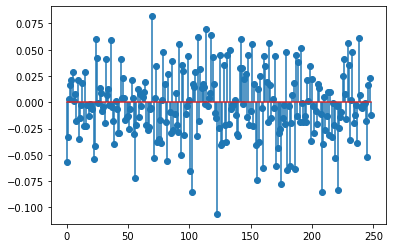

In [4]:
acf = ps.stats.acf(noise, lags=np.arange(250))
plt.stem(acf, use_line_collection=True)

In [5]:
ps.stats.ljung_box(noise, lags=np.arange(5), bin_width=0.5, bin_method="rectangle")

,Q Stat,P-value
Lags (Days),,
1,3.218689,0.072802
2,4.282542,0.117505
3,4.289891,0.231815
4,4.558204,0.335702


In [6]:
#ps.stats.portmanteau(noise, maxlag=5)

## 3. Checking for homoscedasticity
The final assumption we check is if the residuals are so-called homoscedastic, which in practice means that the values of the residuals are independent of the simulated groundwater levels.
The following tests for homoscedasticity are available:

- Visualisation of residuals
- Engle test
- Breusch-Pagaan test

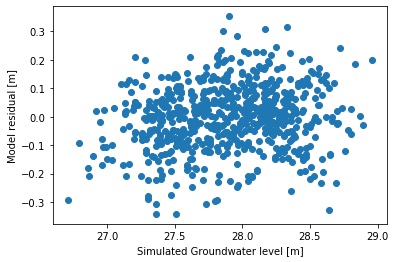

In [7]:
plt.plot(ml.observations(), ml.residuals(), marker="o", linestyle=" ")
plt.xlabel("Simulated Groundwater level [m]")
plt.ylabel("Model residual [m]");

## 2. Checking for Normal distribution
A common assumption is that the residuals follow a Normal distribution, although in principle it is also possible that the residuals come from another distribtion. Testing whether or not a time series comes from a normal distribution is notoriously difficult, especially for larger sample size (e.g., more groundwater level observations). 

An easy method to asses the normality of the residuals is to plot 

The following tests are available:

- Visualisation of residuals
- shapiro-wilk (`scipy.stats.shapiro`)
- D'Agostino (`scipy.stats.normaltest`): This test checks if the noise series comes from a normal distribution (H0 hypothesis)

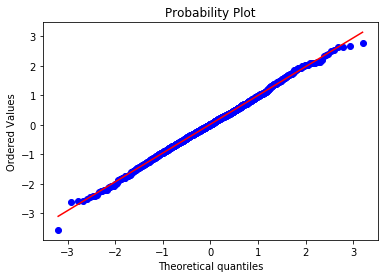

In [8]:
ax = plt.subplot()  # To make the plot, an axes has to be provided
_ = stats.probplot(noise, plot=ax);

In [9]:
stat, p = stats.shapiro(noise)
p < alpha

False

In [10]:
stat, p = stats.normaltest(noise)
p < alpha

False

As the p-value is larger than $\alpha=0.05$ it is possible that the noise series comes from a normal distribution, so the Null hypothesis (series comes from a normal distribution) is not rejected.

## 4. Diagnostics checking in practice
To check all the assumptions mentioned above at once, Pastas has two methods to perform all of the above tests in batch. The first method plots a collection of the visualisations (`ml.plots.diagnostics()`) and the second methods runs all statistical tests in batch (`ml.stats.diagnostics()`). Running these methods for every Pastas Model is recommended when modeling time series with Pastas and doing inferences with a calibrated model.


In [11]:
ps.stats.diagnostics(noise, alpha=0.05)

,Checks,Test. Stat.,P-value,Reject H0 (alpha=0.05)
Shapiroo,Normality,0.998506,0.558602,False
D'Agostino,Normality,0.180541,0.913684,False
Runs test,Autocorrelation,-0.0631509,0.949646,False
Durbin-Watson,Autocorrelation,2.1133,NaN,False
Ljung-Box,Autocorrelation,[0.22944082823025774],[1.0],False


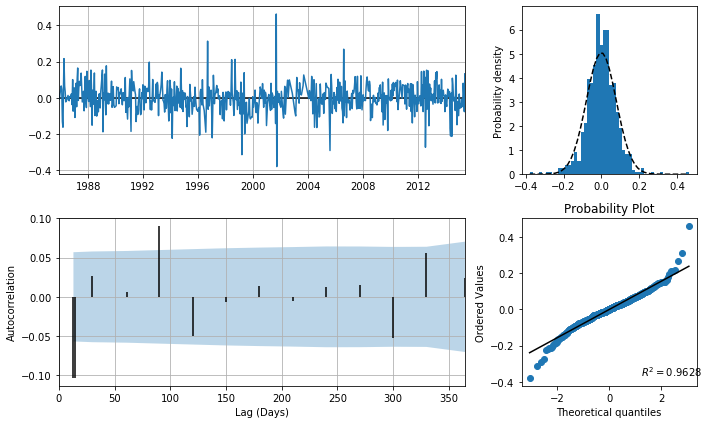

In [12]:
ml.plots.diagnostics();

## Food for thought
- How well do the tests for normality and homoscedasticity work for time series with non-equidistant time steps?
- Should the weighted or unweighted residuals be used for diagnostic checking?
- Could we use the ACF for irregular timesteps in combination with Ljung-Box?
- How to determine the degrees of freedom for a test, just the parameters from the noise model, or also from the deterministic model?

## Further Reading

- Hipel, K. W., & McLeod, A. I. (1994). Time series modelling of water resources and environmental systems, [Chaper 7: Diagnostic Checking.](http://fisher.stats.uwo.ca/faculty/aim/1994Book/1994-Time-chapter%207.pdf) Elsevier.
- Stoffer, D. S., & Toloi, C. M. (1992). A note on the Ljung—Box—Pierce portmanteau statistic with missing data. Statistics & probability letters, 13(5), 391-396.
- D'Agostino, R. and Pearson, E. S. (1973), "Tests for departure from normality", Biometrika, 60, 613-622.
- Ljung, G. and Box, G. (1978). On a Measure of Lack of Fit in Time Series Models, Biometrika, 65, 297-303.
- Durbin, J., & Watson, G. S. (1951). Testing for serial correlation in least squares regression. II. Biometrika, 38(1/2), 159-177.
- Bradley, J. V. (1968). Distribution-free statistical tests.
- 

## Benchmarking built-in Pastas Methods to Statsmodels methods

In [13]:
import statsmodels.api as sm

acf = ps.stats.acf(noise, lags=np.arange(6), bin_width=0.5, bin_method="rectangle")

print("Pastas:", ps.stats.ljung_box(acf=acf, nobs=noise.size).iloc[:, 0].values)
print("Statsmodels:", sm.tsa.q_stat(acf, noise.size)[0])

Pastas: [3.21868876 4.28254158 4.28989126 4.55820353 5.01523582]
Statsmodels: [3.21868876 4.28254158 4.28989126 4.55820353 5.01523582]


In [14]:
print("Pastas:", ps.stats.durbin_watson(noise)[0].round(2))
print("Statsmodels:", sm.stats.durbin_watson(noise).round(2))

Pastas: 2.11
Statsmodels: 2.11
